**IMPORTANT**
You might need to install the SPARQLWrapper and some additional packages, please uncomment the code row below and run the command.

In [1]:
#!pip install SPARQLWrapper
#!pip install matplotlib pandas
#!pip install pandas sqlalchemy mysql-connector-python

In [2]:
from SPARQLWrapper import SPARQLWrapper, JSON
from IPython.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

**MYSQL USER AND PASSWORD**

In [ ]:
user = "root" #you might need to change this
password = "root" #you might need to change this
host = "localhost"

This data analysis aims to investigate the trend in Mental Health Common Disorders over the years. Two Health surveys have been collected to assess the trend and its consequences. One comes from an API that uses SPARQL Technology, and the other is a CSV document that comes from Kaggle.

**INTRO TO SPARQL:**

SPARQL is a query language used to navigate the web. It can return webpages, datasets, videos and more!
It uses an endpoint against which you can your queries. It looks like SQL, but it is not.

This technology allows you to access a given endpoint and retrieve a dataset from it. This developer plans to learn more about this technology in the near future.

You can read more about SPARQL here: 
https://www.ontotext.com/knowledgehub/fundamentals/what-is-sparql/
https://www.w3.org/TR/sparql11-query/

Tutorials:
https://www.youtube.com/watch?v=r7N7s1yejFQ&list=PLea0WJq13cnA6k4B6Tr1ljj2nleUl9dZt&index=1

API DOCUMENTATION:
https://statistics.gov.scot/resource?uri=http%3A%2F%2Fstatistics.gov.scot%2Fdata%2Fscottish-health-survey-scotland-level-data


In [3]:
end_point = "http://statistics.gov.scot/sparql" #API endpoint

In [4]:
sparql = SPARQLWrapper(end_point) # Initialize the SPARQL wrapper with the endpoint URL

The query below took hours to build. Even though I can explain what it does line by line, I am still not confident enough to alter the structure as I cannot predict what results it will yield. At the moment, we can follow the philosophy: 
If it is not broken, do not touch it.

In [5]:
# Set your SPARQL query
sparql.setQuery("""
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX sdmxDimension: <http://purl.org/linked-data/sdmx/2009/dimension#>
PREFIX scotDimension: <http://statistics.gov.scot/def/dimension/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT  ?refAreaLabel ?refPeriodLabel ?indicatorLabel ?sexLabel ?measureTypeLabel ?value
WHERE {
    ?observation a qb:Observation ;
                 sdmxDimension:refArea ?refArea ;
                 sdmxDimension:refPeriod ?refPeriod ;
                 scotDimension:scottishHealthSurveyIndicator ?indicator ;
                 scotDimension:sex ?sex ;
                 qb:measureType ?measureType ;
                 ?measureType ?value .

    OPTIONAL { ?refArea rdfs:label ?refAreaLabel . }
    OPTIONAL { ?refPeriod rdfs:label ?refPeriodLabel . }
    OPTIONAL { ?indicator rdfs:label ?indicatorLabel . }
    OPTIONAL { ?sex rdfs:label ?sexLabel . }
    OPTIONAL { ?measureType rdfs:label ?measureTypeLabel . }
}
LIMIT 11881
""")

In [6]:
sparql.setReturnFormat(JSON) #Return the result as JSON

In [7]:
results = sparql.query().convert() #Run the query, the JSON result will be converted into a Python dictionary

In [8]:
#Redefine the dictionary to display human-readable values instead of URIs.
data = {
    'Area': [result['refAreaLabel']['value'] if 'refAreaLabel' in result else None for result in results["results"]["bindings"]],
    'Year': [result['refPeriodLabel']['value'] if 'refPeriodLabel' in result else None for result in results["results"]["bindings"]],
    'Indicator': [result['indicatorLabel']['value'] if 'indicatorLabel' in result else None for result in results["results"]["bindings"]],
    'Gender': [result['sexLabel']['value'] if 'sexLabel' in result else None for result in results["results"]["bindings"]],
    'MeasureType': [result['measureTypeLabel']['value'] if 'measureTypeLabel' in result else None for result in results["results"]["bindings"]],
    'Value': [result['value']['value'] if 'value' in result else None for result in results["results"]["bindings"]]
}

**INTRO TO CUSTOM FUNCTIONS:**
The next lines will show a set of custom functions to help in the analysis.

In [9]:
#This function helps to display the data into a table format with some CSS.
def set_table_css(data_set:pd.DataFrame):
   data_set.style.set_properties(**{'color': 'black','text-align':'center'})

In [10]:
#This helper function creates a pivot table and avoids code repetition.
def make_pivot_table(dataset:pd.DataFrame)->pd.DataFrame:
    pivot_table = dataset.pivot_table(
    index='Year', 
    columns='Indicator', 
    values='Value',
    aggfunc='first'
    )

    #Reset the index to display the Year column
    pivot_table.reset_index(inplace=True)

    #Ensure Year is stored not as a string.
    pivot_table['Year'] = pd.to_numeric(pivot_table['Year'], errors='coerce', downcast='integer')

    # Skipping the first column ('Year') in this iteration and ensure values are floats
    for column in pivot_table.columns[1:]:  
        pivot_table[column] = pd.to_numeric(pivot_table[column], errors='coerce', downcast='float')

    return pivot_table

In [11]:
#This function renames columns in a friendly and shorter way
def rename_columns(dataset:pd.DataFrame, names:dict)->pd.DataFrame:
    dataset = dataset.rename(columns=names)
    return dataset

In [12]:
#This function prints dataset into CSV files
def print_csv(dataset:pd.DataFrame,path:str):
    dataset.to_csv(path, index=False)

In [13]:
#This function helps to create a DataFrame where for each column, it calculates the Mean, Mode and Median
def create_avg_dataframe(data_set:pd.DataFrame, columns:list)->pd.DataFrame:
    means = []
    modes = []
    medians = []
    for column in columns:
        mean = pd.to_numeric(data_set[column]).mean()
        median = pd.to_numeric(data_set[column]).median()
        mode = pd.to_numeric(data_set[column]).mean()
        means.append(format(mean, '.2f'))
        modes.append(format(mode, '.2f'))
        medians.append(format(median, '.2f'))

    data = {
        "Indicator" : columns,
        "MEAN" : means,
        "MEDIAN" : medians,
        "MODE" : modes
    }

    return pd.DataFrame(data)

**END OF CUSTOM FUNCTIONS;**

In [14]:
data = pd.DataFrame(data) #Put the data obtained by the API into a DataFrame

In [15]:
#filter data to select Scotland only as the file might come with a further background per regions of Scotland
scotland_data = data[data['Area'] == 'Scotland']

In [16]:
#ensure data are ordered by Year in Ascending order
scotland_data = scotland_data.sort_values(by=["Year"], ascending=[True])

In [17]:
#select only the rows where Gender = All and Measure Type is not 95% upper or lower confidence limit 
#ignore the UserWarning.
filtered_data = scotland_data[
    (data['Gender'] == 'All') &
    ~data['MeasureType'].str.contains('confidence limit', case=False, na=False)
]

C:\Users\salva\AppData\Local\Temp\ipykernel_15772\4014550948.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = scotland_data[


In [18]:
#group by 'Year', 'Indicator', 'Sex', 'Measure Type'
grouped_data = filtered_data.groupby(['Year', 'Indicator', 'Gender', 'MeasureType']).agg({'Value': 'first'}).reset_index()

In [19]:
#select only 'Year', 'Indicator',"Value"
grouped_data = grouped_data[['Year', 'Indicator',"Value"]]

**FIRST DATASET:**
The first dataset has a set of voices that must be understood before analysing the data.

**UNDERSTANDING SURVEY'S VOICES:**
The first one we will look at is the GHQ-12 questionnaire.
This questionnaire is used to identify those likely to have or at risk of developing psychiatric disorders.
It is divided into 3 Score Ranges:
Score 0: Non-significant risk.
Score 1-3: Mild risk.
Score 4+: At risk.

However, this is a screening tool and not a diagnostic tool.

In [20]:
#Analyse data about GHQ-12 screening tool; Select only data where Indicator is relevant to GHQ-12
GHQ_12_data = grouped_data[grouped_data['Indicator'].str.contains('GHQ-12', case=False, na=False)]

In [21]:
#make a pivot table for a better overview
pivot_GHQ_12_data = make_pivot_table(GHQ_12_data)

In [22]:
#Rename columns in a friendly and shorter way
pivot_GHQ_12_data = rename_columns(pivot_GHQ_12_data, {
    'General health questionnaire (GHQ-12): Score 0': 'Score_0',
    'General health questionnaire (GHQ-12): Score 1-3': 'Score_1_3',
    'General health questionnaire (GHQ-12): Score 4+': 'Score_4+',}
    )

In [23]:
#give some style to the data to be displayed
set_table_css(pivot_GHQ_12_data)
pivot_GHQ_12_data #display the table.

Indicator,Year,Score_0,Score_1_3,Score_4+
0,2008,61.0,24.0,15.0
1,2009,62.0,24.0,14.0
2,2010,61.0,24.0,15.0
3,2011,60.0,25.0,15.0
4,2012,62.0,23.0,15.0
5,2013,60.0,24.0,16.0
6,2014,61.0,24.0,16.0
7,2015,60.0,24.0,16.0
8,2016,61.0,23.0,15.0
9,2017,60.0,23.0,17.0


In [24]:
#create a dataframe that contains mean, median and mode for each column and print it
columns = ['Score_0','Score_1_3','Score_4+']
avg = create_avg_dataframe(pivot_GHQ_12_data, columns)
set_table_css(avg)
avg

,Indicator,MEAN,MEDIAN,MODE
0,Score_0,59.38,60.00,59.38
1,Score_1_3,24.31,24.00,24.31
2,Score_4+,16.31,16.00,16.31


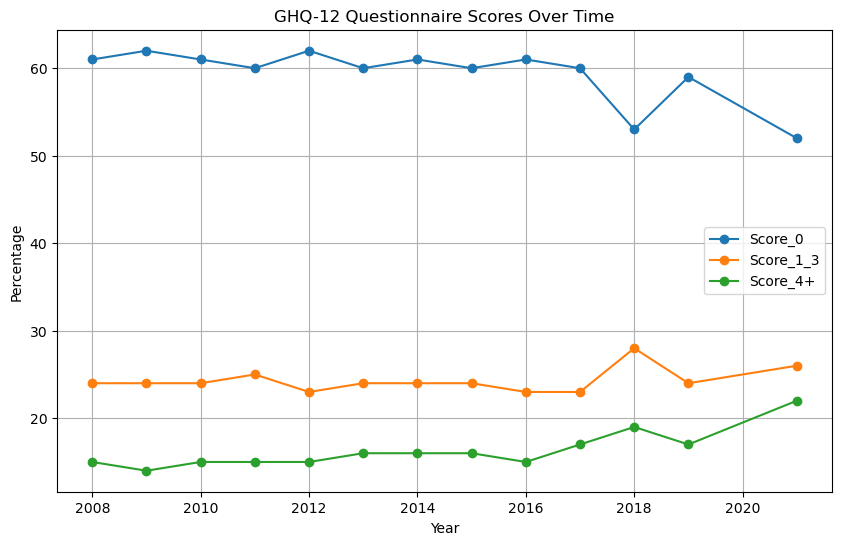

In [25]:
# Create a graphs to better show the trend.
pivot_GHQ_12_data.set_index('Year', inplace=True)
# Plotting directly using Pandas' plot function
pivot_GHQ_12_data.plot(kind='line', figsize=(10, 6), marker='o')
# Adding titles and labels
plt.title('GHQ-12 Questionnaire Scores Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.grid(True)
plt.legend()
# Display the plot
plt.show()

What does this data tell us?

The majority, 60% of the population, scored 0, indicating no psychological distress. This significant portion sets the baseline for our discussion on the Mental Health Status of the population. The remaining 40% scored between 1-3 and 4+, showing some level of distress. The changes in data over the years show a varying trend in the Mental Health Status of the population. Below is a more in-depth background for each score:

Score 0 (No psychological distress):Significant decreases occurred in 2011, 2013, and particularly in 2018 and 2021, which means the population experienced an increase in psychological distresson during these years. However, in 2012 and 2019, there were notable increases in the percentage of the population scoring 0, suggesting improvements in mental health or lower levels of psychological distress.
 
Score 1-3 (Mild psychological distress):
There were significant increases in 2011 and 2018, which means the population experiencing mild psychological distress increased. However, in 2012 and 2019, mild psychological distress levels among the population reduce
d. 
Score 4+ (More severe psychological distress):
There were essential increases in 2010, 2013, 2017, and especially in 2021. This means that a higher proportion of the population experienced more severe levels of psychological distress. In 2009 and 2016, there were improvements in the mental health conditions of the population, with fewer individuals experiencing higher levels of distr
ess. 
IN SUMMARY:
The data reveals that the mental health status of the population, as measured by the GHQ-12, is dynamic, with periods of improvement and decline. The year 2021 stands out with significant increases in more severe psychological distress, whereas years like 2012 and 2019 show improvements in overall mental health, with more individuals scoring 0 on the GHQ-12. These fluctuations could be influenced by various factors, including economic conditions, societal changes, or significant events impacting public health and well-being, such as the 2020 COVID-19 pndemic.
 well-being. ​.

**UNDERSTANDING SURVEY'S VOICES:** The second one we will look at is Mental Well-Being. Unlike the GHQ-12 Questionnaire, this voice measures mental well-being and assesses positive aspects of mental health. This includes feelings of happiness, contentment, engagement with life, and a sense of purpose, meaning, and connection with others.

In other words, the GHQ-12 focuses on assessing people who experience distress, whilst Mental well-being is used to identify people experiencing a more positive attitude towards life.

In [26]:
#Analyse data about Mental Wellbeing; Select only data where Indicator is relevant to Mental
mental_data = grouped_data[grouped_data['Indicator'].str.contains('Mental ', case=False, na=False)]

In [27]:
#make a pivot table for a better overview
pivot_mental_data = make_pivot_table(mental_data)

In [28]:
set_table_css(pivot_mental_data)
pivot_mental_data

Indicator,Year,Mental wellbeing
0,2008,50.000000
1,2009,49.700001
2,2010,49.900002
3,2011,49.900002
4,2012,49.900002
5,2013,50.000000
6,2014,50.000000
7,2015,49.900002
8,2016,49.799999
9,2017,49.799999


In [29]:
#create a dataframe that contains mean, median and mode for each column and print it
columns = ['Mental wellbeing']
avg = create_avg_dataframe(pivot_mental_data, columns)
set_table_css(avg)
avg

,Indicator,MEAN,MEDIAN,MODE
0,Mental wellbeing,49.75,49.90,49.75


On average, the mental well-being score across all years surveyed is around 49.75 out of 100. The median of 49.9 means that half of the mental well-being scores are above 49.9, and half are below it.
The mode of 49.9 further highlights that this particular score is a common measurement of mental well-being among the surveyed years, suggesting it might be a significant representative value for mental well-being in this dataset
.
In conclusion, all average measurements suggest that the mental well-being scores are fairly consistent, hovering around the high 49s out of 100. The fact that the mean, median, and mode are very close to each other also implies that the data does not have extreme variations and might be somewhat symmetrically distributed around the central value of 49.
​​

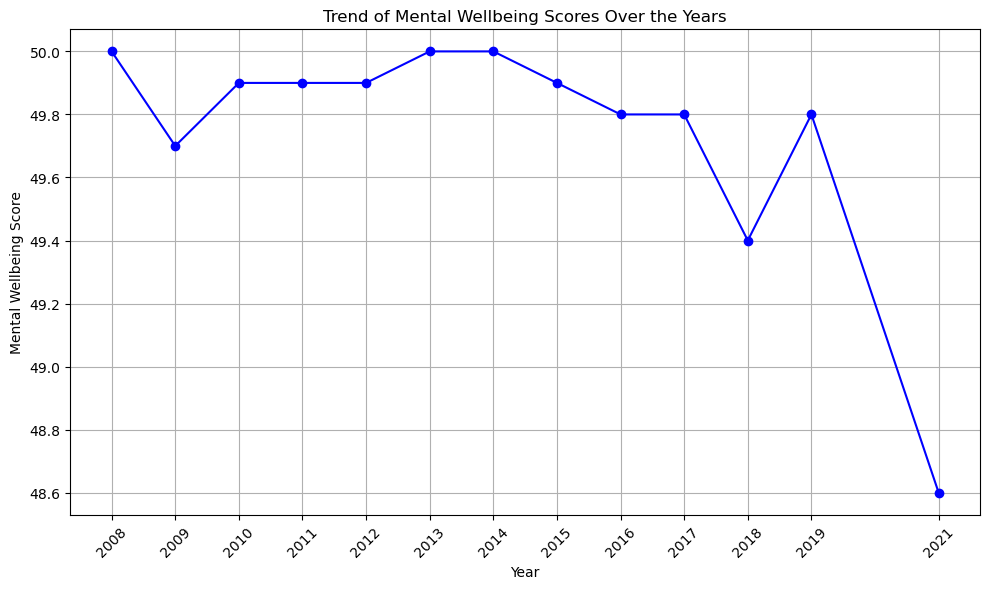

In [30]:
#create a graph to get better insights from the data.
plt.figure(figsize=(10, 6))
plt.plot(pivot_mental_data['Year'], pivot_mental_data['Mental wellbeing'], marker='o', linestyle='-', color='blue')
plt.title('Trend of Mental Wellbeing Scores Over the Years')
plt.xlabel('Year')
plt.ylabel('Mental Wellbeing Score')
plt.grid(True)
plt.xticks(pivot_mental_data['Year'], rotation=45)  # Rotate year labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

Although the mean, median, and mode indicate a central tendency around 49.9, the line graph above provides a clearer picture of any fluctuations, including decreases, throughout the surveyed years.

The data from the two previous dataframes ('pivot_mental_data' and 'pivot_GHQ_12_data') can be comibined together to show the whole picture.

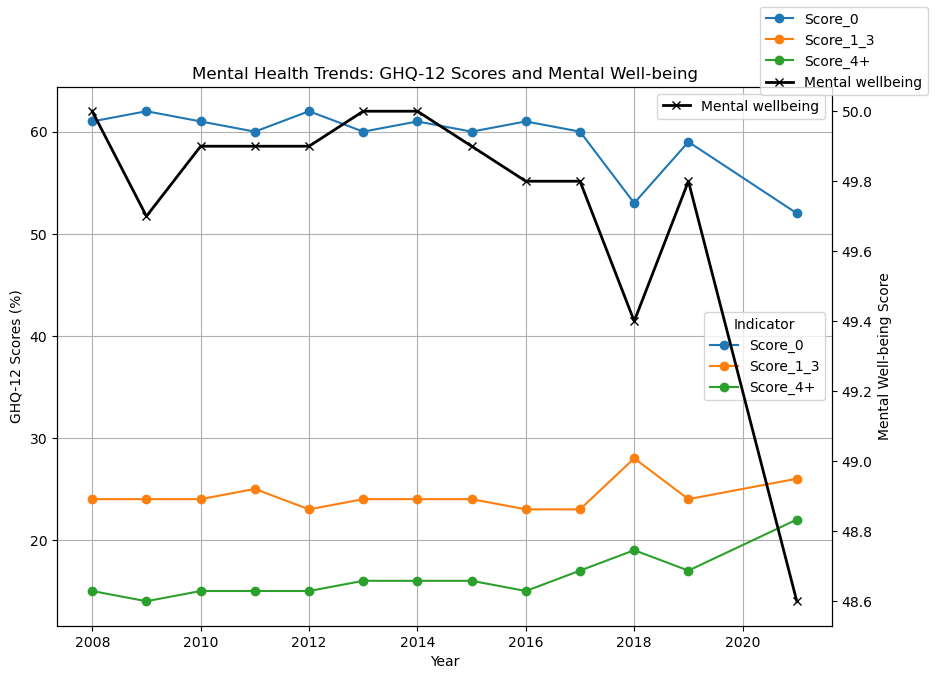

In [31]:
# Create a new figure and axis object
fig, ax1 = plt.subplots(figsize=(10, 7))
pivot_mental_data.set_index('Year', inplace=True)
# Plot GHQ-12 data
pivot_GHQ_12_data.plot(ax=ax1, marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('GHQ-12 Scores (%)')

# Create a second y-axis for the mental well-being score
ax2 = ax1.twinx()
pivot_mental_data['Mental wellbeing'].plot(ax=ax2, color='k', marker='x', linewidth=2, legend=True)
ax2.set_ylabel('Mental Well-being Score')

# Additional settings
ax1.set_title('Mental Health Trends: GHQ-12 Scores and Mental Well-being')
ax1.grid(True)
ax1.figure.legend()

plt.show()

Now, with the whole picture, we can notice, especially after 2020, that the mental well-being indicator dropped significantly. In addition, the HGQ-12 scores follow the same trend to support the claim that mental health among the population has been aggravating. Score 0 (people not suffering from mental health) has declined, whilst Score 1-3 and Score 4 (people suffering from mild to severe mental distress) have increased.

**UNDERSTANDING SURVEY'S VOICES:** The third one is life satisfaction. This indicator has been reported as Mode in the survey.

In [32]:
#Analyse data about Life Satisfaction; Select only data where Indicator is relevant to life
happiness_data = grouped_data[grouped_data['Indicator'].str.contains('Life ', case=False, na=False)]

In [33]:
#make a pivot table for a better overview
pivot_happiness_data = make_pivot_table(happiness_data)

In [34]:
#Rename columns in a friendly and shorter way
pivot_happiness_data = rename_columns(pivot_happiness_data, {
    'Life satisfaction: Above the mode (9 to 10-Extremely satisfied)': 'Extremely_Satisfied',
    'Life satisfaction: Below the mode (0-Extremely dissatisfied to 7)': 'Extremely_Dissatisfied',
    'Life satisfaction: Mode (8)': 'Satisfied',}
    )

In [35]:
set_table_css(pivot_happiness_data)
pivot_happiness_data

Indicator,Year,Extremely_Satisfied,Extremely_Dissatisfied,Satisfied
0,2008,31.0,40.0,30.0
1,2009,31.0,38.0,31.0
2,2010,30.0,40.0,31.0
3,2011,31.0,38.0,31.0
4,2012,32.0,37.0,31.0
5,2013,32.0,36.0,32.0
6,2014,34.0,33.0,32.0
7,2015,33.0,33.0,33.0
8,2016,34.0,34.0,33.0
9,2017,34.0,35.0,31.0


In [36]:
#create a dataframe that contains mean, median and mode for each column and print it
columns = ['Extremely_Satisfied','Extremely_Dissatisfied','Satisfied']
avg = create_avg_dataframe(pivot_happiness_data, columns)
set_table_css(avg)
avg

,Indicator,MEAN,MEDIAN,MODE
0,Extremely_Satisfied,32.77,33.00,32.77
1,Extremely_Dissatisfied,36.23,36.00,36.23
2,Satisfied,31.23,31.00,31.23


The averages above reveal a notable balance in life satisfaction among the respondents. Yet there is a slight indication of more respondents leaning towards extreme dissatisfaction (as the averages for this indicator are higher than the others too). Still, if we add the Satisfied category with the Extremely Satisfied together, the majority of the population considers themselves satisfied (either extremely or normally).

However, a line graph can tell us towards what direction the trend is changing

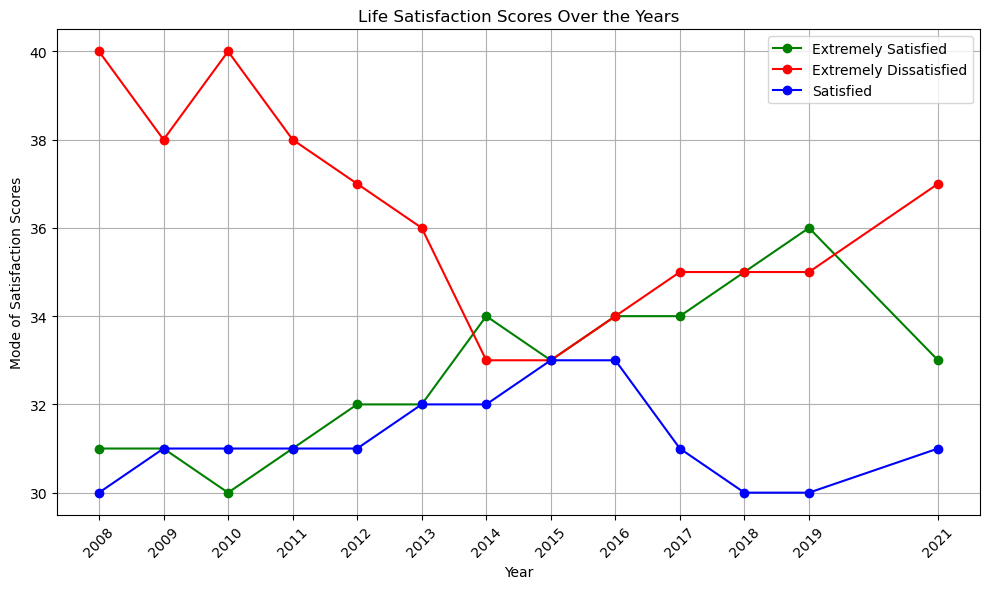

In [37]:
# Plot a line graph about happiness data
plt.figure(figsize=(10, 6))
plt.plot(pivot_happiness_data['Year'], pivot_happiness_data['Extremely_Satisfied'], label='Extremely Satisfied', marker='o', color='green')
plt.plot(pivot_happiness_data['Year'], pivot_happiness_data['Extremely_Dissatisfied'], label='Extremely Dissatisfied', marker='o', color='red')
plt.plot(pivot_happiness_data['Year'], pivot_happiness_data['Satisfied'], label='Satisfied', marker='o', color='blue')

plt.title('Life Satisfaction Scores Over the Years')
plt.xlabel('Year')
plt.ylabel('Mode of Satisfaction Scores')
plt.legend()
plt.grid(True)
plt.xticks(pivot_happiness_data['Year'], rotation=45)
plt.tight_layout()

plt.show()


Indeed, it can be noted that after 2020, people's life satisfaction has been changing. People with an unsatisfied life are on the rise, whilst people who are extremely satisfied are in decline. As to satisfied people, they are actually improving. 

It can be concluded that the level of life satisfication is still good but might need constant monitoring, especially towards those who are not satisfied. This is because this trend might keep rising in the future.

**CUROSIOTY STATS: The number of smokers has decreased over the years, whilst the number of vapers has increased. Even though there is not enough information, it can be assumed that the Demand for tobacco has decreased due to the introduction of vapes into the market, indicating a shift in consumers' tastes and preferences.

Please view the data below: (N.B. This is not related to Mental Health)

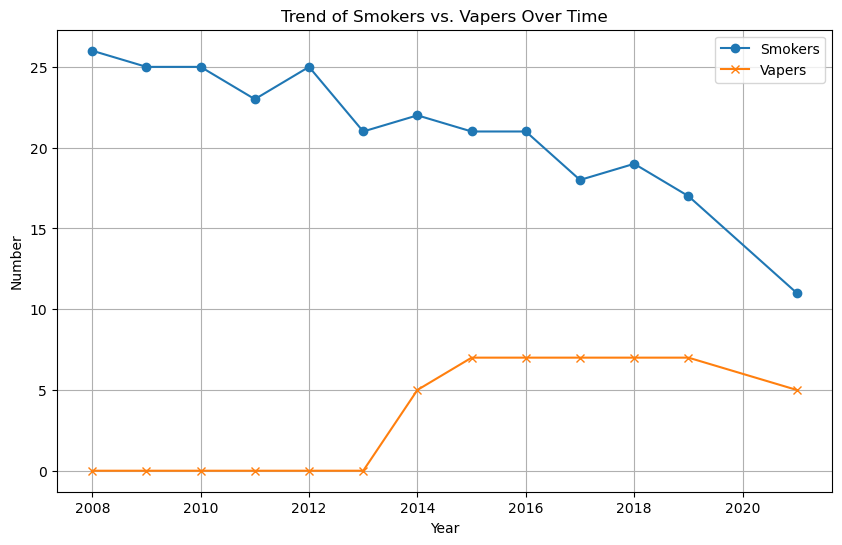

In [38]:
#Analyse data about smoking and e-cigarettes; select only data where the Indicator is relevant to smoking and vaping
smoke_data = grouped_data[
                grouped_data['Indicator'].str.contains('smok', case=False, na=False)
                | grouped_data['Indicator'].str.contains('E-cig', case=False, na=False)
            ]
#make a pivot table for a better overview
pivot_smoking_data = make_pivot_table(smoke_data)

#Rename columns in a friendly and shorter way
pivot_smoking_data = rename_columns(pivot_smoking_data, {
    'Smoking status: Current smoker': 'Smokers',
    'Smoking status: Never smoked/Used to smoke occasionally': 'Never/Occasional_Smokers',
    'Smoking status: Used to smoke regularly': 'Former_Smokers',
    'E-cigarette use: Currently using': 'Vapers',
    'E-cigarette use: Ever previously used': 'Vaped_at_least_once',
    'E-cigarette use: Never used': 'Never_Vaped',}
    )

#Fill potential missing values with zero.
pivot_smoking_data = pivot_smoking_data.fillna(0)

#If you want to view table data, uncomment the next lines.
#set_table_css(pivot_smoking_data)
#pivot_smoking_data

#If you want to view average data uncomment the next lines.
#columns = ['Smokers','Never/Occasional_Smokers','Former_Smokers','Vapers','Vaped_at_least_once','Never_Vaped']
#avg = create_avg_dataframe(pivot_smoking_data, columns)
#set_table_css(avg)
#avg

plt.figure(figsize=(10, 6))
plt.plot(pivot_smoking_data['Year'], pivot_smoking_data['Smokers'], label='Smokers', marker='o')
plt.plot(pivot_smoking_data['Year'], pivot_smoking_data['Vapers'], label='Vapers', marker='x')
plt.title('Trend of Smokers vs. Vapers Over Time')
plt.xlabel('Year')
plt.ylabel('Number')
plt.legend()
plt.grid(True)

The trend over time shows that as vaping becomes more prevalent (noted by the increase in vapers), there's a noticeable decrease in the number of smokers. This visual trend suggests that there could be a correlation between the rise of vaping and the decline in smoking rates.

Again, despite the data suggesting that the introduction of vaping devices could be associated with a decrease in smoking rates, a more detailed analysis would be necessary to assert so.

**INTRO TO THE SECOND DATASET:**
This dataset comes from Kaggle and can be downloaded at https://www.kaggle.com/datasets/thedevastator/uncover-global-trends-in-mental-health-disorder.

This dataset focuses more on mental disorders rather than assessing overall health. The data presented here are for the United Kingdom. Despite the previous dataset focused on Scotland, similar findings are expected in the second dataset to support the claim that mental health is becoming more relevant and affecting the whole country. 

In [39]:
#Load the CSV dataset. Ignore the warning as the file will be cleaned later on
data = pd.read_csv("Mental health Depression disorder Data.csv")

C:\Users\salva\AppData\Local\Temp\ipykernel_15772\2630302325.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("Mental health Depression disorder Data.csv")


In [40]:
#ADDRESSING SOME ISSUES ABOUT THE YEAR COLUMN:
#Ensure the column named Year is converted to numeric, coercing errors to NaN
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
#Drop potential NaN values in the Year column that a result of the previous line
data = data.dropna(subset=['Year'])
# Ensure the Year column is now an integer
data['Year'] = data['Year'].astype(int)

In [41]:
#filter for UK only and select only values since 2008
uk_data = data[(data['Year'] >= 2008) & (data['Code'] == 'GBR')]

In [42]:
#select relevant columns only
uk_data = uk_data[['Year', 'Schizophrenia (%)', 'Bipolar disorder (%)','Eating disorders (%)','Anxiety disorders (%)','Drug use disorders (%)','Depression (%)','Alcohol use disorders (%)']]

In [43]:
#Rename columns in a friendly and shorter way
uk_data = rename_columns(uk_data, {
    'Schizophrenia (%)': 'Schizophrenia',
    'Bipolar disorder (%)': 'Bipolar disorder',
    'Eating disorders (%)': 'Eating disorders',
    'Anxiety disorders (%)': 'Anxiety disorders',
    'Drug use disorders (%)' : 'Drug use disorders',
    'Depression (%)' : 'Depression',
    'Alcohol use disorders (%)' : 'Alcohol use disorders',}
    )

In [44]:
#ensure floats values are actually floats and not strings
for col in uk_data.columns[1:]: #exclude the Year column
    uk_data[col]  = pd.to_numeric(uk_data[col], errors='coerce')

In [45]:
#ensure it is ordered by Year
uk_data = uk_data.sort_values(by='Year')

In [46]:
#drop potential double rows
uk_data = uk_data.drop_duplicates(subset=['Year', 'Schizophrenia', 'Bipolar disorder','Eating disorders','Anxiety disorders','Drug use disorders','Depression','Alcohol use disorders'])

**CONSIDERATION IN CLEANING DATA**
The dataset now comes with some other duplicate values in the column year. However, the values for the other columns are different among different rows. Some rows have a Nan Value, and some others have a value. It is necessary to group these rows together by year and ensure the last value is kept. If the last value is NaN, then it will take the last non-Nan value. 

To make matters worse, some percentage values are totally wrong. For instance, there are values such as 2871254.83144. We need to alter these values to address this and turn data into a more logical (and above all possible) interpretation. Therefore, numbers that do not fall in a range between 1 and 100 will be divided recursively until they fall in the range. It can be assumed that some values have been wrongly reported. For instance, instead of 2871254.83144 maybe it was meant 28.83%. This would turn the data into plausible percentage values. Therefore, the final value should 0.0287125483144.

If you want to see the dataset to better understand the issue, you can uncomment the line below.

In [47]:
#print_csv(uk_data,"uk_data_messed_up.csv")

First, let's fix the percentage issues by a writing a function that for each row it adjust the percentage.

In [48]:
def correct_to_plausible_percentage(row):
    """
    Ensures that values are within a plausible percentage range.
    Continuously divide by 100 until multiplying by 100 does not exceed 100%.
    """
    for col in row.index: 
        if col == 'Year': # Skip the Year column
            continue
        
        val = row[col]
        #Check and adjust the value to ensure it's a plausible percentage
        while pd.notnull(val) and (val * 100) > 100:
            val /= 100
        row[col] = val
    return row

In [49]:
#print the dataset
uk_data = uk_data.apply(correct_to_plausible_percentage, axis=1)
#reset the column year as Integer
uk_data['Year'] = uk_data['Year'].astype(int)
#uncomment the next line if you wish to print the dataset
#print_csv(uk_data,"uk_data_fixed.csv")

Now, we need a function to get to group the rows together by year and ensure the last value is kept. If the last value is NaN, then it will take the last non-Nan value.

In [50]:
def group_rows_fix_values(data_set:pd.DataFrame):
    return data_set.dropna().values[-1] if not data_set.dropna().empty else None

**FUNCTION BREAKDOWN:**

dropna() = drop the rows where one or more cells are NaN. This will return a DataFrame with only rows that have an actual value.

.values[-1] = get this data as a NumPy array. -1 tells the function to keep the last row of the DataFrame.

if not data_set.dropna().empty = check if the DataFrame is not empty. If True the function returns the last row of the DataFrame as a NumPy array. Otherwise, the function returns None which means there are no rows without missing data.

In [51]:
#Group the dataset by Year and Run the function. Lambda runs the function for each row 
uk_data = uk_data.groupby('Year').agg(lambda row: group_rows_fix_values(row))

In [52]:
#Finally, visualise the data:
set_table_css(uk_data)
uk_data
#if you wish to print this file, uncomment the line below
#print_csv(uk_data,"uk_data.csv")

,Schizophrenia,Bipolar disorder,Eating disorders,Anxiety disorders,Drug use disorders,Depression,Alcohol use disorders
Year,,,,,,,
2008,0.032892,0.048815,0.621450,0.046577,0.017616,0.041087,0.018523
2009,0.252212,0.010850,0.537520,0.046655,0.017632,0.041216,0.018897
2010,0.032947,0.049149,0.634600,0.046683,0.017581,0.041268,0.019085
2011,0.032923,0.049179,0.640220,0.046668,0.017485,0.041262,0.019139
2012,0.028146,0.377808,0.645250,0.046648,0.017380,0.041261,0.019174
2013,0.032877,0.049249,0.649840,0.046622,0.017261,0.041258,0.019189
2014,0.256523,0.010856,0.542871,0.046594,0.017130,0.041253,0.019180
2015,0.072729,0.377304,0.658600,0.046563,0.016984,0.041244,0.019144
2016,0.028881,0.010864,0.543352,0.046531,0.016821,0.041225,0.019075


In [53]:
#create a dataframe that contains mean, median and mode for each column and print it
columns = ['Schizophrenia', 'Bipolar disorder','Eating disorders','Anxiety disorders','Drug use disorders','Depression','Alcohol use disorders']
avg = create_avg_dataframe(uk_data, columns)
set_table_css(avg)
avg
#if you wish to print this file, uncomment the line below
#print_csv(avg,"uk_avg.csv")

,Indicator,MEAN,MEDIAN,MODE
0,Schizophrenia,0.10,0.03,0.10
1,Bipolar disorder,0.10,0.05,0.10
2,Eating disorders,0.61,0.64,0.61
3,Anxiety disorders,0.05,0.05,0.05
4,Drug use disorders,0.02,0.02,0.02
5,Depression,0.04,0.04,0.04
6,Alcohol use disorders,0.02,0.02,0.02


Based on the data above, Eating Disorder appears to be the most common disorder with a mean of 61%.

However, since the dataset comes from Kaggle, it cannot be assessed the accuracy of data.

***MIGRATING DATA INTO MYSQL***
**IMPORTANT, MAKE SURE YOUR CONNECTION STRING IS PROPERLY SET. YOU MIGHT NEED TO CHANGE THE USER AND PASSWORD VARIABLES**

In [54]:
#create engine
database_name = "data"
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/')

#create the database if it doesn't exist
with engine.connect() as conn:
    conn.execute(text("CREATE DATABASE IF NOT EXISTS data"))

#connect to the database
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/data')

**START INSERTING THE DATA**

In [55]:
pivot_GHQ_12_data = pivot_GHQ_12_data.reset_index() #necessary to insert the year
pivot_GHQ_12_data.to_sql(name='ghq_12', con=engine, if_exists='replace', index=False)

13

In [56]:
pivot_mental_data = pivot_mental_data.reset_index() #necessary to insert the year
pivot_mental_data.to_sql(name='mental_wellbeing', con=engine, if_exists='replace', index=False)

13

In [57]:
pivot_happiness_data = pivot_happiness_data.reset_index() #necessary to insert the year
pivot_happiness_data.to_sql(name='happiness', con=engine, if_exists='replace', index=False)

13

In [58]:
pivot_smoking_data = pivot_smoking_data.reset_index() #necessary to insert the year
pivot_smoking_data.to_sql(name='smokers', con=engine, if_exists='replace', index=False)

13

In [59]:
uk_data = uk_data.reset_index() #necessary to insert the year
uk_data.to_sql(name='uk_stats', con=engine, if_exists='replace', index=False)

12